**These code cells were run on google colab with GPU support.**

In [1]:
import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


**Fetching the data**

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mnist = fetch_openml("mnist_784")
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


**Plotting one example of each class**

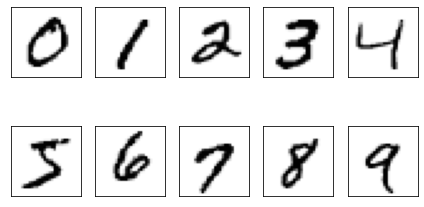

In [3]:
X = mnist["data"]
Y = mnist["target"]
Y = Y.astype(int)
X=(X/255 - 0.5)*2

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    for x, y in zip(X, Y):
        if y==i:
            img=np.array(x).reshape((28,28))
            ax[i].imshow(img, cmap="Greys")
            break
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

**Out of 70k examples, 10k will be used for test set, and remaining will be used for training and validation.**

In [4]:
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in split.split(X_train,Y_train):
    X_train_strat = X_train[train_index, :]
    Y_train_strat = Y_train[train_index]
    X_val_strat = X_train[val_index, :]
    Y_val_strat = Y_train[val_index]

In [6]:
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix


**Extending and overriding methods for our own dataset**

In [7]:

class mnist_dataset(data.Dataset):
    def label_transformer(self, labels):
        return labels

    def __init__(self, input_data, labels):
        input_data = input_data.reshape((len(input_data),1,28,28))
        self.feats = input_data
        self.labels = self.label_transformer(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        x = self.feats[index]
        y = self.labels[index]
        return x,y


**Creating dataloader for each of the train, validation, test dataset.**

In [8]:
class hyperparam:
    bs = 100
    lr = 0.05
    num_epochs = 50

params = {
    "batch_size": hyperparam.bs,
    "shuffle": True,
    "num_workers": 2,
    "drop_last": False,
    "pin_memory": True
}

train_set = mnist_dataset(X_train_strat, Y_train_strat)
val_set = mnist_dataset(X_val_strat, Y_val_strat)
test_set = mnist_dataset(X_test, Y_test)

training_gen = data.DataLoader(train_set, **params)
val_gen = data.DataLoader(val_set, **params)
test_gen = data.DataLoader(test_set, **params)

**Created a DNN with 2 layers of CNN with 12 filters each and adding two fully connected layers of 100 and 10 neurons respectively.
Used Relu activation function, with initial learning rate = 0.05 with glorot initialization.**

In [9]:
from torch.nn import Conv2d, Linear
from torch import flatten

class baseline_cnn(nn.Module):
    
    def glorot_initialize(self, layers):
        
        for layer in layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)
    
    def __init__(self):
        super(baseline_cnn, self).__init__()
        self.conv1 = Conv2d(1,12,kernel_size=(3,3), padding = 1)
        self.conv2 = Conv2d(12,12,kernel_size=(3,3), padding = 1)
        self.fc1 = Linear(588, 100)
        self.fc2 = Linear(100, 10)
        
        self.glorot_initialize([self.conv1, self.conv2, self.fc1, self.fc2])
        
        
    def forward(self, sig):
        sig = Func.max_pool2d(Func.relu(self.conv1(sig)), (2, 2))
        sig = Func.max_pool2d(Func.relu(self.conv2(sig)), (2, 2))
        sig = sig.view(-1, 12*7*7)
        sig = Func.relu(self.fc1(sig))
        sig = self.fc2(sig)
        return sig
        # return Func.softmax(sig, dim = 1)

cnn_model = baseline_cnn().to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = hyperparam.lr, momentum=0.9) # TODO ADAM optimizer
loss = nn.CrossEntropyLoss()

**Model is trained for 50 epochs, after each epochs, printing the validation accuracy. and resulting learning rate after adjusting learning rate by 10% each 10 epochs
Also using early stopping mechanism, which stops the learning if the validation accuracy starts dropping for a consecutive 5 cycles. This is done to prevent overfitting.**

In [10]:
from tqdm import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

tr_avg_loss_list = []
tr_accuracy_list = []
val_avg_loss_list = []
val_accuracy_list = []

print(datetime.now())

for epoch in tqdm(range(hyperparam.num_epochs)):
    tr_num_correct = 0
    tr_num_samples = 0
    tr_total_loss = 0
    val_num_correct = 0
    val_num_samples = 0
    val_total_loss = 0
    
    print("Learning rate: " + str(optimizer.param_groups[0]['lr']))

    cnn_model.train(True)
    with torch.set_grad_enabled(True):
        for ind, (local_batch, local_labels) in enumerate(training_gen):
            
            optimizer.zero_grad()
            local_batch = local_batch
            local_labels = local_labels
            local_batch, local_labels = Variable(local_batch).float(), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            
            ploss = loss(out1, local_labels.long())
            tr_total_loss += ploss * hyperparam.bs
            ploss.backward()
            optimizer.step()
            sel_class = torch.argmax(out1, dim=1)
            tr_num_correct += sel_class.eq(local_labels).sum().item()
            tr_num_samples += hyperparam.bs
                
                                  
        tr_avg_loss = tr_total_loss / len(training_gen.dataset)
        tr_avg_loss_list.append(tr_avg_loss)
        tr_accuracy = tr_num_correct / len(training_gen.dataset)
        tr_accuracy_list.append(tr_accuracy)
    
    with torch.set_grad_enabled(False):
        cnn_model.eval()
        for local_batch, local_labels in val_gen:
            local_batch = local_batch.float()
            local_labels = local_labels.float()
            local_batch, local_labels = Variable(local_batch), Variable(local_labels)
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)
            out1 = cnn_model(local_batch)
            ploss = loss(out1, local_labels.long())
            val_total_loss += ploss * hyperparam.bs
            sel_class = torch.argmax(out1, dim=1)
            val_num_correct += sel_class.eq(local_labels).sum().item()
            val_num_samples += local_labels.size(0)

        val_avg_loss = val_total_loss / len(val_gen.dataset)
        val_avg_loss_list.append(val_avg_loss)
        val_accuracy = val_num_correct / len(val_gen.dataset)
        val_accuracy_list.append(val_accuracy)
        print("Validation accuracy: " + str(val_accuracy))

        scheduler.step()

        # Early stop
        if epoch > 10:
            if sum([val_accuracy_list[i] < val_accuracy_list[i-1] for i in range(epoch-5, epoch)]) == 5:
                break
        

  0%|          | 0/50 [00:00<?, ?it/s]

2021-04-11 07:59:01.817748
Learning rate: 0.05


  2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

Validation accuracy: 0.977
Learning rate: 0.05


  4%|▍         | 2/50 [00:05<02:12,  2.77s/it]

Validation accuracy: 0.9796666666666667
Learning rate: 0.05


  6%|▌         | 3/50 [00:07<02:05,  2.68s/it]

Validation accuracy: 0.9826666666666667
Learning rate: 0.05


  8%|▊         | 4/50 [00:10<02:00,  2.62s/it]

Validation accuracy: 0.9851666666666666
Learning rate: 0.05


 10%|█         | 5/50 [00:12<01:56,  2.58s/it]

Validation accuracy: 0.9836666666666667
Learning rate: 0.05


 12%|█▏        | 6/50 [00:15<01:52,  2.56s/it]

Validation accuracy: 0.986
Learning rate: 0.05


 14%|█▍        | 7/50 [00:17<01:48,  2.53s/it]

Validation accuracy: 0.985
Learning rate: 0.05


 16%|█▌        | 8/50 [00:20<01:45,  2.52s/it]

Validation accuracy: 0.9881666666666666
Learning rate: 0.05


 18%|█▊        | 9/50 [00:22<01:43,  2.52s/it]

Validation accuracy: 0.9868333333333333
Learning rate: 0.05


 20%|██        | 10/50 [00:25<01:40,  2.51s/it]

Validation accuracy: 0.986
Learning rate: 0.045000000000000005


 22%|██▏       | 11/50 [00:27<01:37,  2.51s/it]

Validation accuracy: 0.9863333333333333
Learning rate: 0.045000000000000005


 24%|██▍       | 12/50 [00:30<01:34,  2.50s/it]

Validation accuracy: 0.9878333333333333
Learning rate: 0.045000000000000005


 26%|██▌       | 13/50 [00:32<01:32,  2.50s/it]

Validation accuracy: 0.9876666666666667
Learning rate: 0.045000000000000005


 28%|██▊       | 14/50 [00:35<01:30,  2.50s/it]

Validation accuracy: 0.9865
Learning rate: 0.045000000000000005


 30%|███       | 15/50 [00:37<01:27,  2.51s/it]

Validation accuracy: 0.9871666666666666
Learning rate: 0.045000000000000005


 32%|███▏      | 16/50 [00:40<01:25,  2.51s/it]

Validation accuracy: 0.9881666666666666
Learning rate: 0.045000000000000005


 34%|███▍      | 17/50 [00:42<01:22,  2.50s/it]

Validation accuracy: 0.9865
Learning rate: 0.045000000000000005


 36%|███▌      | 18/50 [00:45<01:19,  2.50s/it]

Validation accuracy: 0.987
Learning rate: 0.045000000000000005


 38%|███▊      | 19/50 [00:47<01:17,  2.49s/it]

Validation accuracy: 0.9833333333333333
Learning rate: 0.045000000000000005


 40%|████      | 20/50 [00:50<01:14,  2.49s/it]

Validation accuracy: 0.9886666666666667
Learning rate: 0.04050000000000001


 42%|████▏     | 21/50 [00:52<01:12,  2.48s/it]

Validation accuracy: 0.9891666666666666
Learning rate: 0.04050000000000001


 44%|████▍     | 22/50 [00:55<01:09,  2.48s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.04050000000000001


 46%|████▌     | 23/50 [00:57<01:06,  2.47s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.04050000000000001


 48%|████▊     | 24/50 [01:00<01:04,  2.47s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.04050000000000001


 50%|█████     | 25/50 [01:02<01:01,  2.46s/it]

Validation accuracy: 0.9895
Learning rate: 0.04050000000000001


 52%|█████▏    | 26/50 [01:05<00:59,  2.47s/it]

Validation accuracy: 0.9895
Learning rate: 0.04050000000000001


 54%|█████▍    | 27/50 [01:07<00:56,  2.47s/it]

Validation accuracy: 0.9895
Learning rate: 0.04050000000000001


 56%|█████▌    | 28/50 [01:10<00:54,  2.48s/it]

Validation accuracy: 0.9895
Learning rate: 0.04050000000000001


 58%|█████▊    | 29/50 [01:12<00:52,  2.48s/it]

Validation accuracy: 0.9895
Learning rate: 0.04050000000000001


 60%|██████    | 30/50 [01:15<00:49,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 62%|██████▏   | 31/50 [01:17<00:47,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 64%|██████▍   | 32/50 [01:20<00:44,  2.49s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 66%|██████▌   | 33/50 [01:22<00:42,  2.49s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 68%|██████▊   | 34/50 [01:25<00:39,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 70%|███████   | 35/50 [01:27<00:37,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 72%|███████▏  | 36/50 [01:30<00:34,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 74%|███████▍  | 37/50 [01:32<00:32,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 76%|███████▌  | 38/50 [01:34<00:29,  2.48s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 78%|███████▊  | 39/50 [01:37<00:27,  2.48s/it]

Validation accuracy: 0.9895
Learning rate: 0.03645000000000001


 80%|████████  | 40/50 [01:39<00:24,  2.47s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 82%|████████▏ | 41/50 [01:42<00:22,  2.48s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 84%|████████▍ | 42/50 [01:44<00:19,  2.49s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 86%|████████▌ | 43/50 [01:47<00:17,  2.49s/it]

Validation accuracy: 0.9896666666666667
Learning rate: 0.03280500000000001


 88%|████████▊ | 44/50 [01:49<00:14,  2.49s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 90%|█████████ | 45/50 [01:52<00:12,  2.50s/it]

Validation accuracy: 0.9896666666666667
Learning rate: 0.03280500000000001


 92%|█████████▏| 46/50 [01:54<00:10,  2.51s/it]

Validation accuracy: 0.9896666666666667
Learning rate: 0.03280500000000001


 94%|█████████▍| 47/50 [01:57<00:07,  2.50s/it]

Validation accuracy: 0.9895
Learning rate: 0.03280500000000001


 96%|█████████▌| 48/50 [01:59<00:05,  2.51s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


 98%|█████████▊| 49/50 [02:02<00:02,  2.52s/it]

Validation accuracy: 0.9893333333333333
Learning rate: 0.03280500000000001


100%|██████████| 50/50 [02:05<00:00,  2.50s/it]

Validation accuracy: 0.9895


**Plotting learning curves for validation and train dataset**

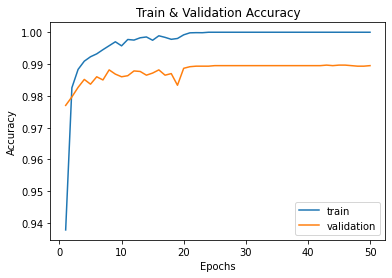

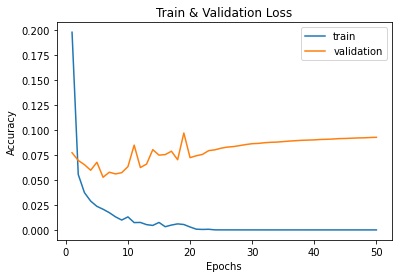

In [18]:
def plot_x_y_vals(x_vals, y_vals, x_label, y_label, label, line_titles):
    for i in range(len(x_vals)):
        plt.plot(x_vals[i], y_vals[i], label=line_titles[i])
    plt.title(label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

epocs = [i+1 for i in range(len(tr_accuracy_list))]
plot_x_y_vals([epocs, epocs], [tr_accuracy_list, val_accuracy_list], "Epochs", "Accuracy", "Train & Validation Accuracy", ["train", "validation"])
plot_x_y_vals([epocs, epocs], [tr_avg_loss_list, val_avg_loss_list], "Epochs", "Accuracy", "Train & Validation Loss", ["train", "validation"])

**Overfit or Underfit?**

In the above learning curves we see that, a very high accuracy on both training and validation set is observed. While the training accuracy is almost 1, the validation accuracy is very close to one, and is around ~0.99.

From the loss plot, we see that train loss is almost zero while validation loss, even though very less, has been increasing by very small amount each epoch in the end.

In the plot, even though plot looks to be diverging but since the scale is very small, the plots arent actually that far apart. However seeing almost 100% accuracy and slight increase in the validation loss, towards the end of the epochs, we can say that the model ever so slightly overfits, but still good results nonetheless.

**Checking the accuracy of test set**

In [19]:
total_accurate = 0
total_values = 0
errors={i:{j:0 for j in range(10)} for i in range(10)}
incorrect_samples = []
correct_samples = []

def calculate_class_wise_errors(local_labels, sel_class, local_batch):
    true_labels = local_labels[sel_class.not_equal(local_labels)]
    predicted = sel_class[sel_class.not_equal(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[t.item()][p.item()] += 1
    
    true_labels = local_labels[sel_class.eq(local_labels)]
    predicted = sel_class[sel_class.eq(local_labels)]
    for (i, t), (i,p) in zip(enumerate(true_labels), enumerate(predicted)):
        errors[t.item()][p.item()] += 1

    if len(incorrect_samples) < 10:
        samples = local_batch[sel_class.not_equal(local_labels)]
        predicted = sel_class[sel_class.not_equal(local_labels)]
        true_labels = local_labels[sel_class.not_equal(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            incorrect_samples.append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

    if len(correct_samples) < 10:
        samples = local_batch[sel_class.eq(local_labels)]
        predicted = sel_class[sel_class.eq(local_labels)]
        true_labels = local_labels[sel_class.eq(local_labels)]
        for (i,s), (i,p), (i, t) in zip(enumerate(samples), enumerate(predicted), enumerate(true_labels)):
            correct_samples.append((s.cpu().numpy(), p.cpu().numpy(), t.cpu().numpy()))

with torch.set_grad_enabled(False):
    cnn_model.eval()
    for local_batch, local_labels in test_gen:
        local_batch = local_batch.float()
        local_labels = local_labels.float()
        local_batch, local_labels = Variable(local_batch), Variable(local_labels)
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)
        out1 = cnn_model(local_batch)
        ploss = loss(out1, local_labels.long())
        sel_class = torch.argmax(out1, dim=1)
        calculate_class_wise_errors(local_labels, sel_class, local_batch)
        total_accurate += sel_class.eq(local_labels).sum().item()
        total_values += local_labels.size(0)

    

In [2]:
print("Predicted " + str(total_accurate) +" correctly out of " + str(total_values))


Predicted 9914 correctly out of 10000


**We see that on test set as well we have the accuracy almost equal to 99.14%, which is good. Below we are plotting the heatmap, where y-axis represents the actual label and x-axis represents the predicted labels. Pleaase mind that all the diagonal elements have been set to zero. So the heatmap only represents the incorrectly classified label counts.**

**For example row = 4, col = 3 represents the count of images, which were 4, but were actually classified as 3. And the cell (4,4) is left empty, although it should ideally contain count of all the correctly classified images of 4. As this heatmap is generated only to see if there is any pair that is mistaken a lot in the classification OR if there is any bias in our model for any label.** 


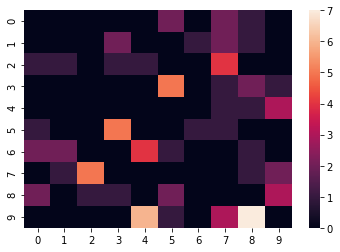

In [21]:
import seaborn as sns
class_acc = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        if i!=j:
            class_acc[i,j] = errors[i][j]
        else:
            class_acc[i,j] = 0

sns.heatmap(class_acc)
plt.show()

**Plotting few incorrectly classified images by our model. We see that these images are ambiguous and little bit hard to interpret or blurry. Each image contains the true value - predicted value pair on top of it.**

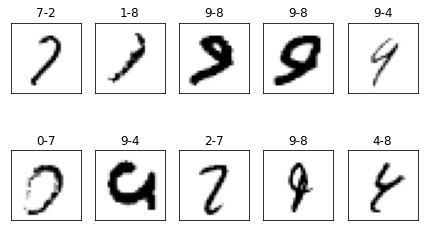

Incorrectly classified samples. (True and predicted values)


In [22]:

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img=np.array(incorrect_samples[i][0]).reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
    ax[i].title.set_text(str(int(incorrect_samples[i][2])) + "-" + str(incorrect_samples[i][1]))
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

print("Incorrectly classified samples. (True and predicted values)")

**Plotting few correctly classified images by our model.**

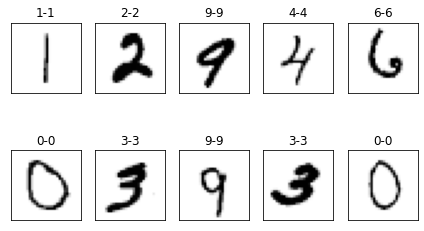

Correctly classified samples. (true and predicted values)


In [23]:

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img=np.array(correct_samples[i][0]).reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
    ax[i].title.set_text(str(int(correct_samples[i][2])) + "-" + str(correct_samples[i][1]))
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

print("Correctly classified samples. (true and predicted values)")

**Plotting below confusion matrix for each class. By each class, we mean all the correct prediction fot that class = true positive. all the images of a class, that were incorrectly classfied as false negative. All the images, not of that class, but classified as of that class as false positive. And all the images that were not of a class and were also classified as not belonging to that class as true negative.**

In [24]:
import pandas as pd
# Confusion matrix
confusion_arr = np.zeros((10, 4))
for i in range(10):
    confusion_arr[i][0] = errors[i][i] # tp
    for j in range(10):
        if i!=j:
            confusion_arr[i][1]+=errors[j][i] # fp
    for j in range(10):
        if i!=j:
            confusion_arr[i][2]+= errors[i][j] # fn
    confusion_arr[i][3] = total_values - sum(confusion_arr[i][:3]) # tn

confusion_df = pd.DataFrame(confusion_arr, columns=["tp", "fp", "fn", "tn"])

confusion_df["precision"] = confusion_df["tp"] / (confusion_df["tp"] + confusion_df["fp"])
confusion_df["recall"] = confusion_df["tp"] / (confusion_df["tp"] + confusion_df["fn"])
confusion_df["accuracy"] = (confusion_df["tp"] + confusion_df["tn"]) / 10000

print("Overall Accuracy:" + str(total_accurate/total_values))

confusion_df


Overall Accuracy:0.9914


,tp,fp,fn,tn,precision,recall,accuracy
0,975.0,6.0,5.0,9014.0,0.993884,0.994898,0.9989
1,1129.0,4.0,6.0,8861.0,0.996470,0.994714,0.9990
2,1024.0,6.0,8.0,8962.0,0.994175,0.992248,0.9986
3,1001.0,9.0,9.0,8981.0,0.991089,0.991089,0.9982
4,977.0,11.0,5.0,9007.0,0.988866,0.994908,0.9984
5,884.0,11.0,8.0,9097.0,0.987709,0.991031,0.9981
6,948.0,2.0,10.0,9040.0,0.997895,0.989562,0.9988
7,1019.0,14.0,9.0,8958.0,0.986447,0.991245,0.9977
8,965.0,14.0,9.0,9012.0,0.985700,0.990760,0.9977
9,992.0,9.0,17.0,8982.0,0.991009,0.983152,0.9974


**Here it is to be noted that, true negative has a very high value count, and that is expected. Because it contains almost all the images of other classes, except given class.**

We see that SGD optimizer, with momentum = 0.9 and glorot initialization, achieves a really good accuracy of ~99%. On running SGD optimizer multiple times, with early stopping, a lot of time the training process stopped around 30 epochs itself. 

It can be observed that from the learning curves that, model achieves a good accuracy in very few epochs. In other words, it descends fast. In the first 3-4 epochs itself it achieves the validation accuracy around 98%

We also see that CNN works really great for images. CrossEntropyLoss seems suitable matrix for multi-class classification and it shows in the results as well.

Another sign that our model is not overfitted is, how the incorrect examples are spread through out all classes. We observe the precision and recall values, those are almost similar. Usually overfitted model tends to favor one class over the other, that is not observed here.

The misclassified examples are also very obscure and hard to iterpret for a machine. Overall the model has performed really well.